In [53]:
import numpy as np
import math
import time
from datetime import datetime, timezone
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [54]:
subjects_as_ints = [3509524, 5132496, 1066528, 5498603, 2638030, 2598705,
                    5383425, 1455390, 4018081, 9961348,1449548, 8258170,
                    781756, 9106476, 8686948, 8530312, 3997827, 4314139,
                    1818471, 4426783, 8173033, 7749105, 5797046, 759667,
                    8000685, 6220552, 844359, 9618981, 1360686, 46343,
                    8692923]

subjects_as_ints_min = [3509524, 5132496]

datetime_string = "2023-12-10 22:00:00"
dt = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S")
BASE_TIME = int(dt.replace(tzinfo=timezone.utc).timestamp())

In [55]:
def read_all_accelerations(subjects):
    df = pd.DataFrame()
    for sub_id in subjects:
        sub_data = read_acceleration(sub_id)
        df = pd.concat([df, sub_data], ignore_index=True)
    return df

def read_acceleration(sub_id):
    data = pd.read_csv('data/motion/' + str(sub_id) + '_acceleration.txt', delimiter=' ').values
    time = data[:,0]
    time = BASE_TIME + time
    time = pd.to_datetime(time, unit='s')
    df = pd.DataFrame({'time': time, 'x': data[:,1], 'y': data[:, 2], 'z': data[:,3], 'ID': sub_id})
    return df

In [56]:
accelerations = read_all_accelerations(subjects_as_ints)
print(accelerations.head())
print(len(accelerations))
print(accelerations.isnull().sum())

                           time         x         y         z       ID
0 2023-12-10 15:16:07.036429882  0.042816  0.117325 -0.993820  3509524
1 2023-12-10 15:16:07.036827087  0.051605  0.113922 -0.993637  3509524
2 2023-12-10 15:16:07.037204027  0.057892  0.115890 -0.991074  3509524
3 2023-12-10 15:16:07.052771091  0.052109  0.118805 -0.995087  3509524
4 2023-12-10 15:16:07.073024988  0.047256  0.118301 -0.996155  3509524
51819120
time    0
x       0
y       0
z       0
ID      0
dtype: int64


In [57]:
labels = pd.read_csv('labels.csv', parse_dates=['time']) 

In [58]:
def crop_extra(data):
    df = pd.DataFrame()
    for _, (subject_id, subject_labels) in enumerate(labels.groupby('ID')):
        print('subject_id: {}'.format(subject_id))
        start = subject_labels['time'].min()
        end = subject_labels['time'].max()
        print('start: {}, end: {}'.format(start, end))
        condition1 = data['ID'] == subject_id
        condition2 = data['time'] >= start
        condition3 = data['time'] <= end
        filtered = data[(condition1 & condition2 & condition3)]
        og = data[condition1]
        print('Number of datapoints: {}'.format(len(filtered)))
        print('percentage of original: {}'.format(len(filtered) / len(og)))
        df = pd.concat([df, filtered], ignore_index=True)
    return df

In [59]:
accelerations = crop_extra(accelerations)

subject_id: 46343
start: 2023-12-10 22:06:30, end: 2023-12-11 02:43:00
Number of datapoints: 830483
percentage of original: 0.8457065638559713
subject_id: 759667
start: 2023-12-10 22:00:30, end: 2023-12-11 01:57:00
Number of datapoints: 869030
percentage of original: 0.7315073497536614
subject_id: 781756
start: 2023-12-10 22:00:30, end: 2023-12-11 06:10:00
Number of datapoints: 1465438
percentage of original: 0.9351875782945618
subject_id: 844359
start: 2023-12-10 22:22:00, end: 2023-12-11 05:50:00
Number of datapoints: 1341320
percentage of original: 0.9212368964539124
subject_id: 1066528
start: 2023-12-10 22:00:30, end: 2023-12-11 05:55:30
Number of datapoints: 1186403
percentage of original: 0.9261545090979775
subject_id: 1360686
start: 2023-12-10 22:09:00, end: 2023-12-11 06:02:30
Number of datapoints: 1380534
percentage of original: 0.886298502863306
subject_id: 1449548
start: 2023-12-10 22:05:30, end: 2023-12-11 06:02:00
Number of datapoints: 1600509
percentage of original: 0.883

In [60]:
for _, (subject_id, subject_data) in enumerate(accelerations.groupby('ID')):
    diff = subject_data['time'].diff()
    print('Average difference: {}'.format(diff.mean()))

Average difference: 0 days 00:00:00.019976330
Average difference: 0 days 00:00:00.016328557
Average difference: 0 days 00:00:00.020041791
Average difference: 0 days 00:00:00.020009846
Average difference: 0 days 00:00:00.023907758
Average difference: 0 days 00:00:00.020061050
Average difference: 0 days 00:00:00.017863063
Average difference: 0 days 00:00:00.019997533
Average difference: 0 days 00:00:00.019992887
Average difference: 0 days 00:00:00.020515001
Average difference: 0 days 00:00:00.016260922
Average difference: 0 days 00:00:00.015141510
Average difference: 0 days 00:00:00.017484464
Average difference: 0 days 00:00:00.015460623
Average difference: 0 days 00:00:00.019993321
Average difference: 0 days 00:00:00.017494884
Average difference: 0 days 00:00:00.015640624
Average difference: 0 days 00:00:00.099955291
Average difference: 0 days 00:00:00.020088739
Average difference: 0 days 00:00:00.017480581
Average difference: 0 days 00:00:00.017480548
Average difference: 0 days 00:00:0

In [61]:
# take average value per second
df = pd.DataFrame()
for _, (subject_id, subject_data) in enumerate(accelerations.groupby('ID')):
    subject_data.sort_values('time', inplace=True)
    resampled = subject_data.resample('S', on='time').mean()
    result = pd.DataFrame({
        'time': resampled.index,
        'x': resampled['x'].values,
        'y': resampled['y'].values,
        'z': resampled['z'].values,
        'ID': resampled['ID'].values
    })
    df = pd.concat([df, result], ignore_index=True)
accelerations = df
print(len(accelerations))

776266


In [62]:
for _, (subject_id, subject_data) in enumerate(accelerations.groupby('ID')):
    diff = subject_data['time'].diff()
    print('Average difference: {}'.format(diff.mean()))

Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.046849638
Average difference: 0 days 00:00:01.003382302
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.194676101
Average difference: 0 days 00:00:01.002316322
Average difference: 0 days 00:00:01.098478444
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.169475578
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.009888918
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.001009009
Average difference: 0 days 00:00:01.000307482
Average difference: 0 days 00:00:01.003556956
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01
Average difference: 0 days 00:00:01.035028248
Average difference: 0 days 00:00:01.014667420
Average difference: 0 days 00:00:01
Average differen

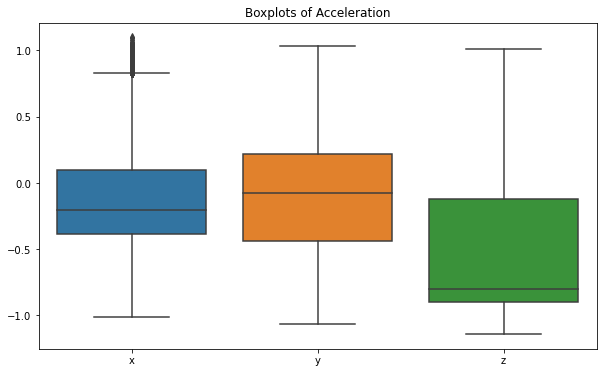

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = accelerations[['x', 'y', 'z']])
plt.title('Boxplots of Acceleration')
plt.show()

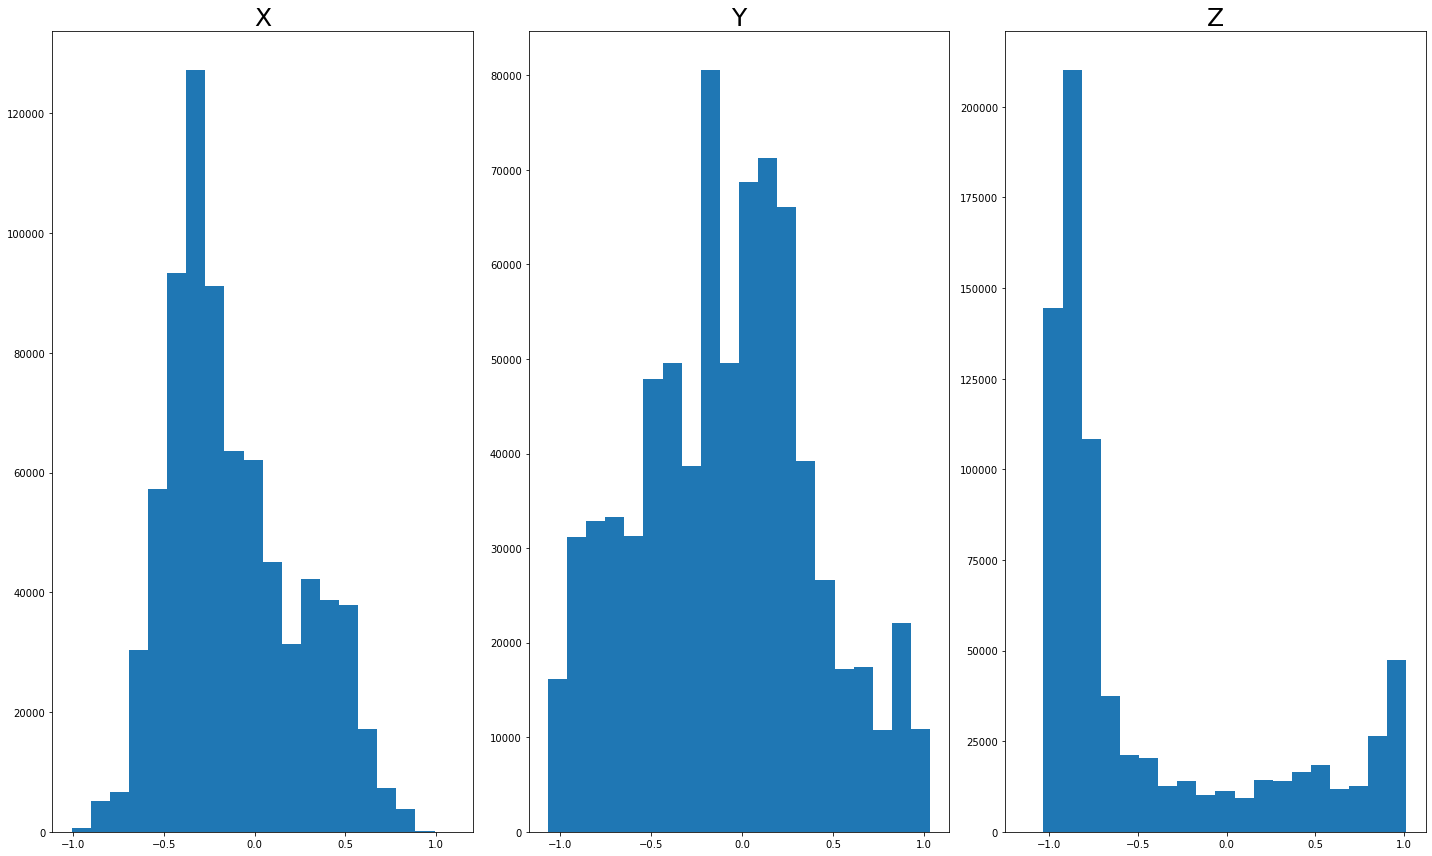

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))

axes[0].hist(accelerations['x'], bins=20)
axes[0].set_title('X', fontsize=25)
axes[1].hist(accelerations['y'], bins=20)
axes[1].set_title('Y', fontsize=25)
axes[2].hist(accelerations['z'], bins=20)
axes[2].set_title('Z', fontsize=25)
plt.tight_layout()
plt.show()

In [69]:
def remove_outliers_trim(data, column):
    lower = data[column].quantile(0.0001)
    upper = data[column].quantile(0.999)
    print('Lower: {}, upper: {}'.format(lower, upper))
    filtered = data[(data[column] >= lower) & (data[column] <= upper)]
    return filtered

In [70]:
accelerations = remove_outliers_trim(accelerations, 'x')
accelerations = remove_outliers_trim(accelerations, 'y')
accelerations = remove_outliers_trim(accelerations, 'z')

Lower: -0.9590671154516501, upper: 0.8282877411280012
Lower: -0.999847039870645, upper: 0.98399201593
Lower: -1.0021395842586005, upper: 1.0047062516233827


In [71]:
scaler = MinMaxScaler()
accelerations['x'] = scaler.fit_transform(accelerations[['x']])
accelerations['y'] = scaler.fit_transform(accelerations[['y']])
accelerations['z'] = scaler.fit_transform(accelerations[['z']])

In [72]:
len(accelerations)

758734

In [74]:
removed = 776266 - 758734
print(removed)
print(removed / 776266)

17532
0.022585041725387948


In [49]:
accelerations.head()

,time,x,y,z,ID
0,2023-12-10 22:06:30,0.298920,0.968821,0.452466,46343.0
1,2023-12-10 22:06:31,0.285728,0.915542,0.385316,46343.0
2,2023-12-10 22:06:32,0.277026,0.890772,0.285245,46343.0
3,2023-12-10 22:06:33,0.259930,0.906690,0.461052,46343.0
4,2023-12-10 22:06:34,0.303545,0.937795,0.453302,46343.0


In [50]:
accelerations.to_csv('accelerations.csv', index=False)

<ipython-input-51-61d6eaa1fa10>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


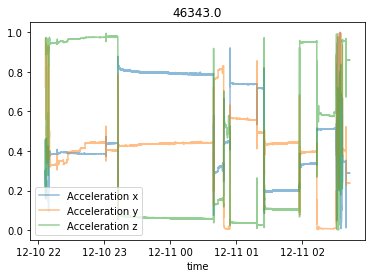

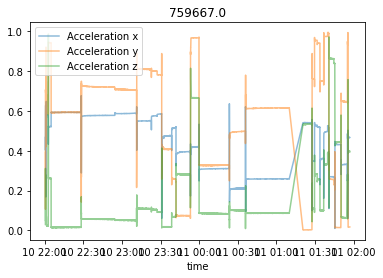

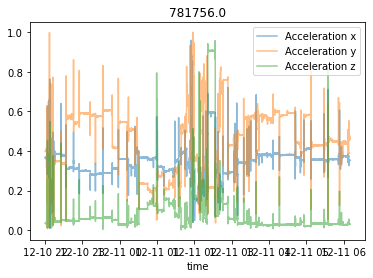

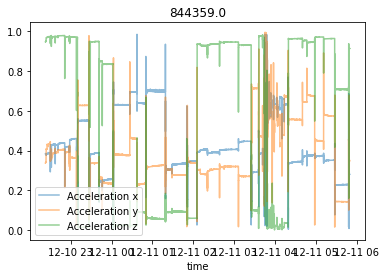

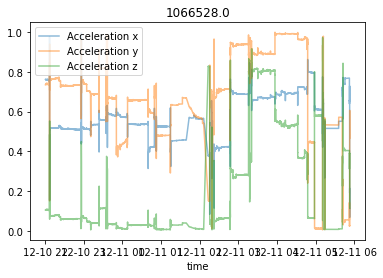

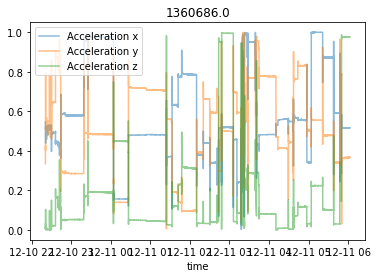

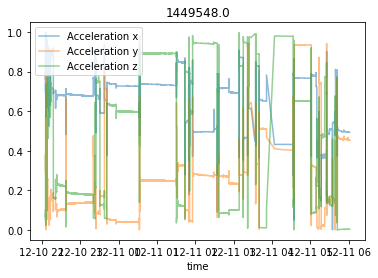

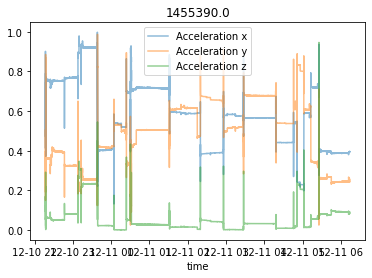

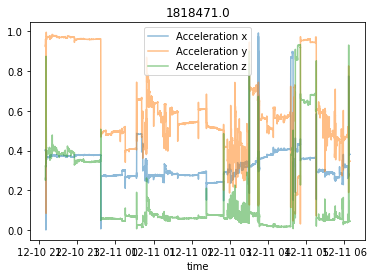

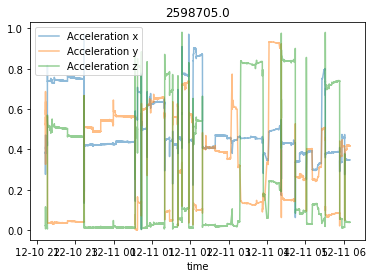

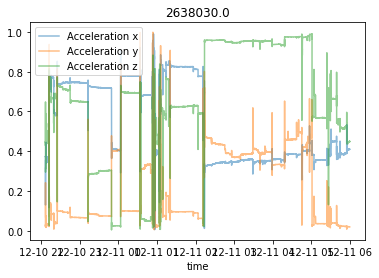

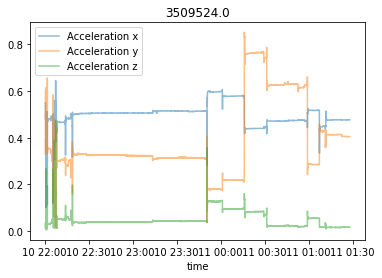

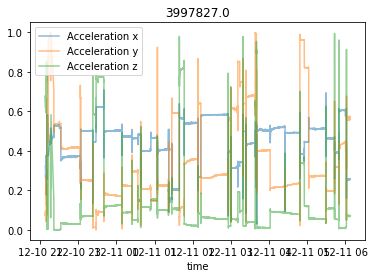

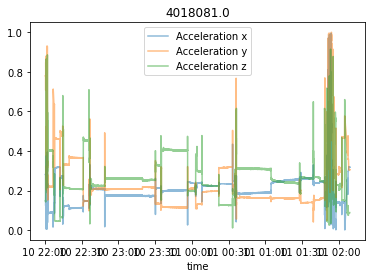

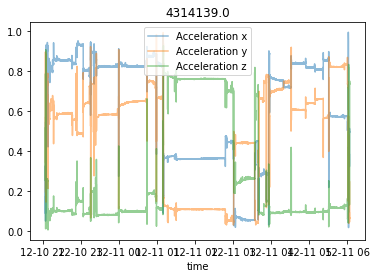

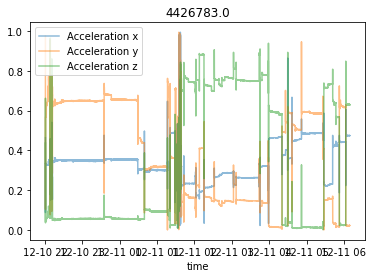

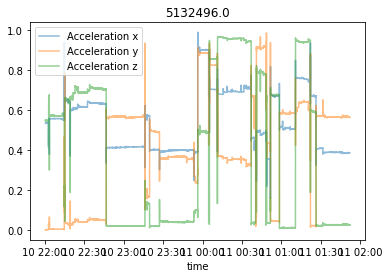

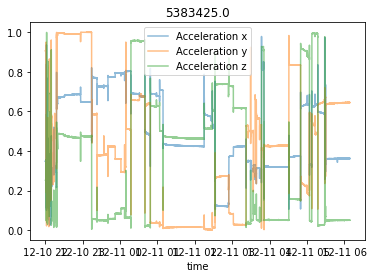

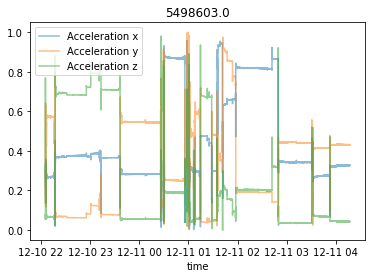

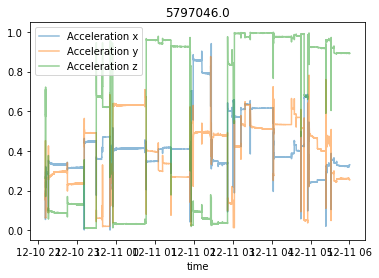

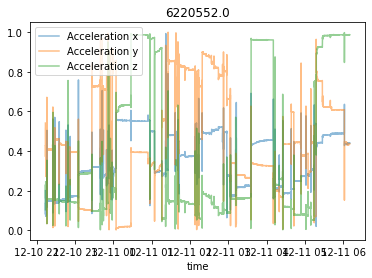

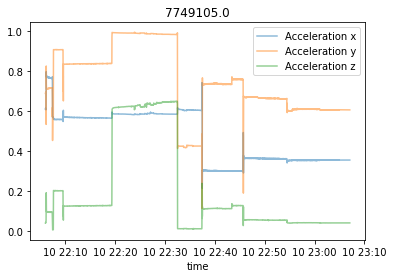

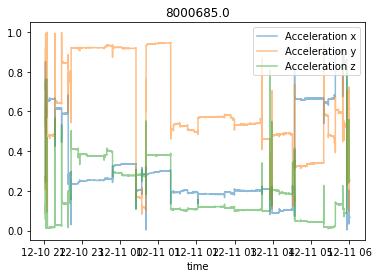

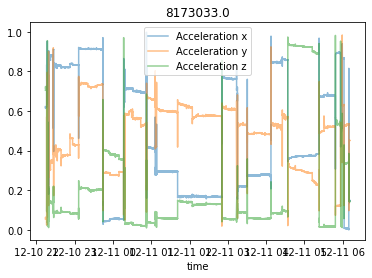

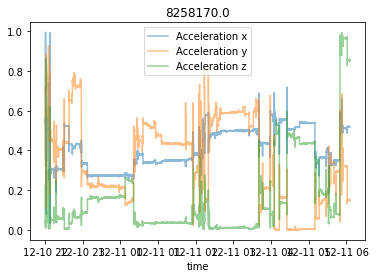

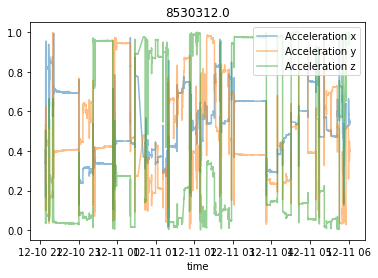

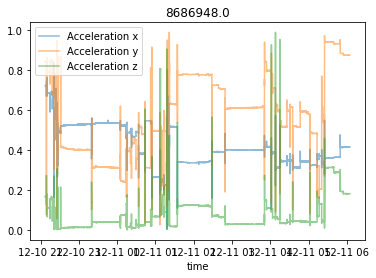

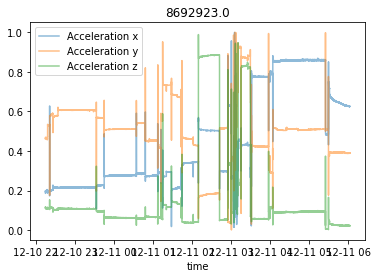

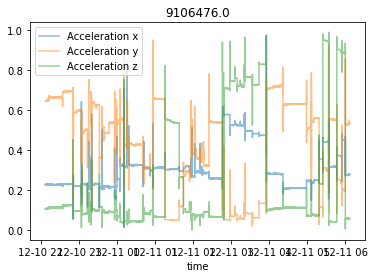

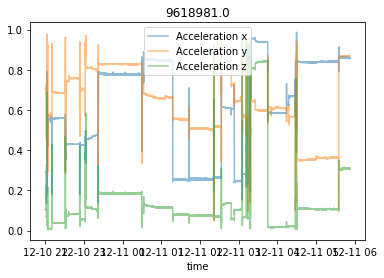

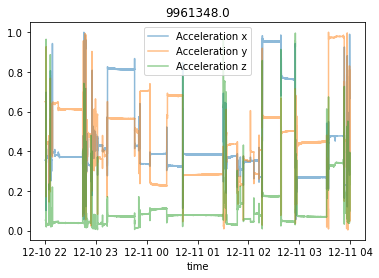

In [51]:
for _, (subject_id, data) in enumerate(accelerations.groupby('ID')):
    plt.figure()
    plt.plot(data['time'], data['x'], label='Acceleration x', alpha=0.5)
    plt.plot(data['time'], data['y'], label='Acceleration y', alpha=0.5)
    plt.plot(data['time'], data['z'], label='Acceleration z', alpha=0.5)
    plt.xlabel('time')
    plt.title(subject_id)
    plt.legend()

plt.show()